In [188]:
import spacy
import pandas as pd
import numpy as np
import nltk

In [189]:
from normalization import normalize_corpus

In [190]:
movie_data =  pd.read_csv('../dataset/movieDescriptionDataSet.tsv', sep='\t')

In [191]:
movie_titles = movie_data['Title'].tolist();
movie_synopses = movie_data['Description'].tolist()
movie_genre = movie_data['Genre'].tolist()

In [192]:
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)




In [193]:
#CREATE FILE WITH THE NORMALIZED CORPUS
norm_movie_synopses_DF = pd.DataFrame(norm_movie_synopses ,columns=['normalized_corpus'])
norm_movie_synopses_DF.to_csv('movieDescriptionDataSetProcessed.tsv', index=False, encoding='utf-8' , sep='\t')

In [194]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#TFID VECTORIZER





In [56]:
vectorizer2 = TfidfVectorizer(min_df=0.021, max_df=0.99,ngram_range=(1, 2))
feature_matrix1 = vectorizer2.fit_transform(norm_movie_synopses).astype(float)
print (feature_matrix1.shape) 

(398, 210)


In [57]:
feature_names2 = vectorizer2.get_feature_names()
print (feature_names2[:20])

['across', 'adventure', 'agent', 'alien', 'along', 'america', 'american', 'army', 'around', 'arrive', 'attack', 'attempt', 'away', 'battle', 'beautiful', 'become', 'begin', 'behind', 'believe', 'best']


In [211]:

vectorizer = TfidfVectorizer(max_features=400)
feature_matrix = vectorizer.fit_transform(norm_movie_synopses).astype(float)
print (feature_matrix.shape) 


(398, 400)


In [212]:
feature_names = vectorizer.get_feature_names()
print (feature_names[:400])

['accidentally', 'across', 'action', 'adventure', 'agent', 'aid', 'alien', 'ally', 'along', 'america', 'american', 'another', 'apart', 'ape', 'army', 'around', 'arrive', 'attack', 'attempt', 'away', 'bad', 'band', 'bank', 'base', 'batman', 'battle', 'beautiful', 'become', 'begin', 'behind', 'believe', 'best', 'big', 'black', 'bond', 'book', 'boy', 'break', 'bright', 'bring', 'british', 'brother', 'bruce', 'building', 'buzz', 'caesar', 'call', 'captain', 'care', 'career', 'case', 'catch', 'cause', 'century', 'challenge', 'chance', 'change', 'chaos', 'child', 'christmas', 'city', 'close', 'complete', 'confront', 'conspiracy', 'continue', 'control', 'cop', 'could', 'country', 'course', 'create', 'creature', 'crew', 'crime', 'criminal', 'danger', 'dangerous', 'dark', 'daughter', 'day', 'dead', 'deadly', 'deal', 'death', 'decide', 'desperate', 'despite', 'destroy', 'detective', 'determine', 'die', 'disaster', 'discover', 'discovery', 'dr', 'draw', 'dream', 'earth', 'effort', 'embark', 'emer

In [197]:
from sklearn.cluster import KMeans

In [198]:
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

In [199]:
num_clusters = 10

In [91]:
distortions = []
K = range(1, 100)
for i in K:
    kmeans = KMeans(n_clusters = i, max_iter=10000)
    kmeans.fit(feature_matrix)
    distortions.append(kmeans.inertia_)

KeyboardInterrupt: 

In [152]:
%matplotlib inline

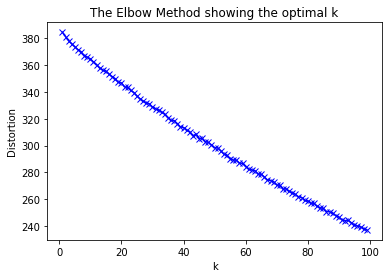

In [76]:
import matplotlib.pyplot as plt

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [200]:
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters


In [201]:
from collections import Counter


In [202]:
c = Counter(clusters)
print (c.items())

dict_items([(7, 36), (3, 41), (8, 27), (5, 33), (9, 30), (4, 51), (1, 56), (2, 56), (6, 29), (0, 39)])


In [203]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()        
        genres = movie_data[movie_data['Cluster'] == cluster_num]['Genre'].values.tolist()
        
        cluster_details[cluster_num]['key_features'] = key_features
        cluster_details[cluster_num]['movies'] = movies
        cluster_details[cluster_num]['genres'] = genres
    
    return cluster_details
        
       
    
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print ('-'*20)
        print ('Key features: (', cluster_details['key_features'] , ')')
        print ('Movies in this cluster: (', len(cluster_details['movies']) , ')')
        print (', '.join(cluster_details['movies']))
        
        print ('Movie genres:')
        
        s = list()
        for genre in cluster_details['genres']:
            #print (genre.split(','))
            for aa in genre.split(','):
                s.append(aa)
                
        counter=Counter(s)  
        
        #print (', '.join(cluster_details['genres']))
        print ('-'*20)
        #print (s)
        print(counter)
        #print (', '.join(s))
        
        print ('='*40)

cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ( ['game', 'world', 'agent', 'must', 'family'] )
Movies in this cluster: ( 39 )
Bumblebee, Avengers: Endgame, Braven, Tag, Jurassic World: Fallen Kingdom, The Nutcracker and the Four Realms, Skyscraper, Sicario: Day of the Soldado, Ready Player One, Maze Runner: The Death Cure, Guardians of the Galaxy Vol. 2, Game Night, Rampage, Escape Plan 2: Hades, The Darkest Minds, Kin, Pixels, X-Men: Apocalypse, Operation Finale, John Wick: Chapter 2, Saw, Men in Black II, Men in Black, Spirited Away, Iron Man 3, Dr. No, Ex Machina, Final Score, Jumanji: Welcome to the Jungle, Death Race 2, Dumplin', Divergent, Skyfall, Wreck-It Ralph, Casino Royale, Monsters, Inc., The Twilight Saga: Breaking Dawn - Part 2, The Hunger Games: Catching Fire, Wind River
Movie genres:
--------------------
Counter({'ACTION': 25, 'ADVENTURE': 20, 'SCIENCE FICTION': 18, 'THRILLER': 12, 'COMEDY': 10, 'DRAMA': 8, 'FANTASY': 7, 'CRIME': 6, 'FAMILY': 4, 'MYSTERY': 4, 'A

The Equalizer 2, Speed Kills, Under the Silver Lake, Death Race 4: Beyond Anarchy, Seventh Son, BlacKkKlansman, John Wick, The Hunger Games: Mockingjay - Part 1, Pirates of the Caribbean: Dead Man's Chest, Nightcrawler, The Greatest Showman, Coco, The Godfather, Jurassic World, Adrift, Birdman, La La Land, The Guilty, Blindspotting, Saving Private Ryan, One Flew Over the Cuckoo's Nest, Overboard, Pitch Perfect 2, The Twilight Saga: New Moon, Hidden Figures, Joy, All the Money in the World, Hacksaw Ridge, White Boy Rick
Movie genres:
--------------------
Counter({'DRAMA': 18, 'CRIME': 10, 'THRILLER': 9, 'COMEDY': 9, 'ADVENTURE': 7, 'ACTION': 5, 'ROMANCE': 4, 'FANTASY': 3, 'HISTORY': 3, 'MYSTERY': 2, 'SCIENCE FICTION': 2, 'WAR': 2, 'ANIMATION': 1, 'FAMILY': 1, 'MUSIC': 1})
Cluster 7 details:
--------------------
Key features: ( ['future', 'human', 'past', 'earth', 'universe'] )
Movies in this cluster: ( 36 )
Venom, Mortal Engines, The Predator, The Nun, The Meg, Solo: A Star Wars Story, 

In [204]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

C:\Users\V622980\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


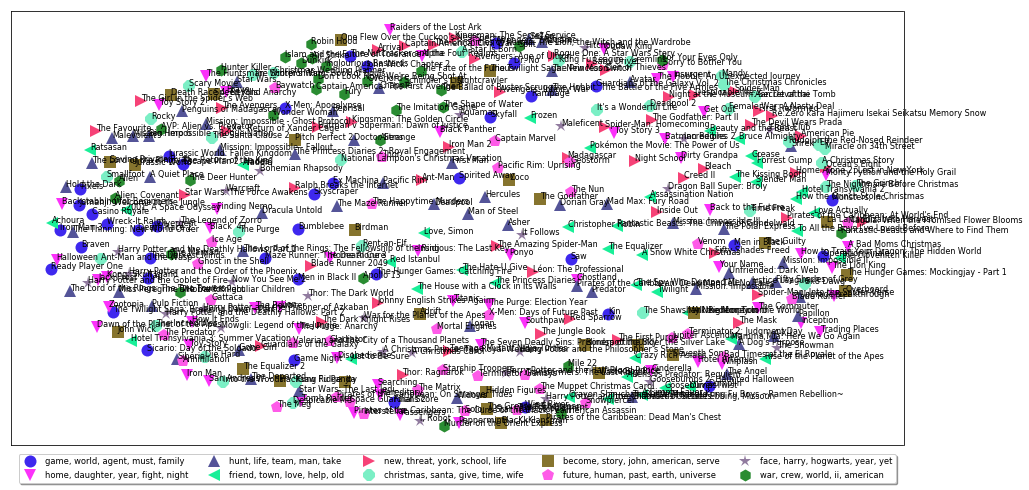

In [205]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))  

In [213]:
from sklearn.cluster import AffinityPropagation
              
def affinity_propagation(feature_matrix):
    
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters

In [214]:
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

In [215]:
c = Counter(clusters)   
print (c.items()  )


dict_items([(0, 8), (54, 8), (11, 7), (24, 7), (33, 9), (1, 6), (2, 7), (15, 8), (3, 9), (43, 6), (4, 10), (35, 7), (58, 5), (5, 6), (8, 6), (12, 6), (32, 7), (37, 6), (6, 11), (29, 6), (47, 6), (55, 8), (18, 7), (49, 4), (21, 5), (56, 8), (10, 6), (53, 5), (40, 8), (50, 7), (36, 6), (28, 6), (38, 10), (27, 7), (51, 4), (45, 9), (7, 5), (13, 8), (26, 6), (31, 6), (17, 10), (9, 5), (20, 8), (46, 8), (25, 7), (48, 7), (19, 5), (22, 5), (23, 6), (41, 6), (14, 4), (30, 5), (44, 7), (34, 10), (39, 5), (16, 9), (52, 6), (42, 6), (57, 3)])


In [216]:
total_clusters = len(c)
print ('Total Clusters:', total_clusters)

Total Clusters: 59


In [217]:
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ( ['accidentally', 'enemy', 'dead', 'resistance', 'old'] )
Movies in this cluster: ( 8 )
Venom, Fifty Shades Freed, A Dog's Purpose, The Little Mermaid, Rampage, The Polar Express, Pirates of the Caribbean: At World's End, Siberia
Movie genres:
--------------------
Counter({'FANTASY': 5, 'ADVENTURE': 4, 'DRAMA': 3, 'ROMANCE': 3, 'SCIENCE FICTION': 2, 'FAMILY': 2, 'ACTION': 2, 'COMEDY': 1, 'ANIMATION': 1, 'CRIME': 1, 'THRILLER': 1})
Cluster 1 details:
--------------------
Key features: ( ['alien', 'brother', 'aid', 'create', 'survival'] )
Movies in this cluster: ( 6 )
Bohemian Rhapsody, Kung Fu League, Deadpool 2, Die Hard, Big Hero 6, Scary Movie
Movie genres:
--------------------
Counter({'ACTION': 4, 'COMEDY': 4, 'ADVENTURE': 2, 'DRAMA': 1, 'MUSIC': 1, 'THRILLER': 1, 'FAMILY': 1, 'ANIMATION': 1})
Cluster 2 details:
--------------------
Key features: ( ['ally', 'mount', 'mind', 'power', 'question'] )
Movies in this cluster: ( 7 )
R

Counter({'DRAMA': 5, 'ADVENTURE': 3, 'COMEDY': 3, 'ROMANCE': 2, 'SCIENCE FICTION': 2, 'THRILLER': 2, 'MYSTERY': 1, 'ACTION': 1, 'FANTASY': 1, 'CRIME': 1, 'ANIMATION': 1, 'FAMILY': 1})
Cluster 17 details:
--------------------
Key features: ( ['face', 'ii', 'destroy', 'catch', 'ex'] )
Movies in this cluster: ( 10 )
Just to Be Sure, The First Purge, Tomb Raider, Bad Times at the El Royale, Mamma Mia! Here We Go Again, A Snow White Christmas, Cinderella, My Neighbor Totoro, Jack Frost, Ponyo
Movie genres:
--------------------
Counter({'DRAMA': 4, 'FANTASY': 4, 'FAMILY': 4, 'COMEDY': 3, 'ROMANCE': 3, 'ACTION': 2, 'THRILLER': 2, 'ANIMATION': 2, 'SCIENCE FICTION': 1, 'HORROR': 1, 'ADVENTURE': 1, 'CRIME': 1, 'MYSTERY': 1, 'TV MOVIE': 1})
Cluster 18 details:
--------------------
Key features: ( ['figure', 'deal', 'red', 'king', 'battle'] )
Movies in this cluster: ( 7 )
A Star Is Born, Hotel Transylvania 3: Summer Vacation, Pirates of the Caribbean: The Curse of the Black Pearl, Pirates of the C

The Predator, Smallfoot, Transformers: The Last Knight, The Matrix, Jupiter Ascending, Pacific Rim: Uprising, Captain Marvel, Sorry to Bother You, The Fifth Element
Movie genres:
--------------------
Counter({'SCIENCE FICTION': 8, 'ACTION': 7, 'ADVENTURE': 7, 'FANTASY': 5, 'THRILLER': 3, 'COMEDY': 2, 'ANIMATION': 1, 'FAMILY': 1})
Cluster 34 details:
--------------------
Key features: ( ['may', 'epic', 'ethan', 'hold', 'program'] )
Movies in this cluster: ( 10 )
Iron Man, Captain America: Civil War, Doctor Strange, Insurgent, xXx: Return of Xander Cage, Mad Max: Fury Road, Warcraft, Iron Man 2, Now You See Me 2, Arrival
Movie genres:
--------------------
Counter({'ACTION': 9, 'ADVENTURE': 8, 'SCIENCE FICTION': 7, 'THRILLER': 4, 'FANTASY': 2, 'CRIME': 1, 'COMEDY': 1, 'DRAMA': 1, 'MYSTERY': 1})
Cluster 35 details:
--------------------
Key features: ( ['men', 'heart', 'recruit', 'apart', 'king'] )
Movies in this cluster: ( 7 )
Ralph Breaks the Internet, Zootopia, Pulp Fiction, Frozen, Adri

Key features: ( ['state', 'head', 'late', 'son', 'hero'] )
Movies in this cluster: ( 7 )
Night School, Assassination Nation, Dirty Grandpa, The Commuter, Papillon, Bleach, Your Name.
Movie genres:
--------------------
Counter({'COMEDY': 3, 'ACTION': 3, 'DRAMA': 3, 'THRILLER': 2, 'ADVENTURE': 2, 'FANTASY': 1, 'ROMANCE': 1, 'ANIMATION': 1})
Cluster 51 details:
--------------------
Key features: ( ['struggle', 'thief', 'effort', 'terrorist', 'captain'] )
Movies in this cluster: ( 4 )
Black Panther, Inside Out, Madagascar, The Devil Wears Prada
Movie genres:
--------------------
Counter({'DRAMA': 2, 'COMEDY': 2, 'ANIMATION': 2, 'FAMILY': 2, 'ACTION': 1, 'ADVENTURE': 1, 'FANTASY': 1, 'SCIENCE FICTION': 1, 'ROMANCE': 1})
Cluster 52 details:
--------------------
Key features: ( ['team', 'united', 'mount', 'give', 'prove'] )
Movies in this cluster: ( 6 )
Nightcrawler, Coco, The Guilty, Saving Private Ryan, Hidden Figures, Hacksaw Ridge
Movie genres:
--------------------
Counter({'DRAMA': 5, 'H

C:\Users\V622980\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


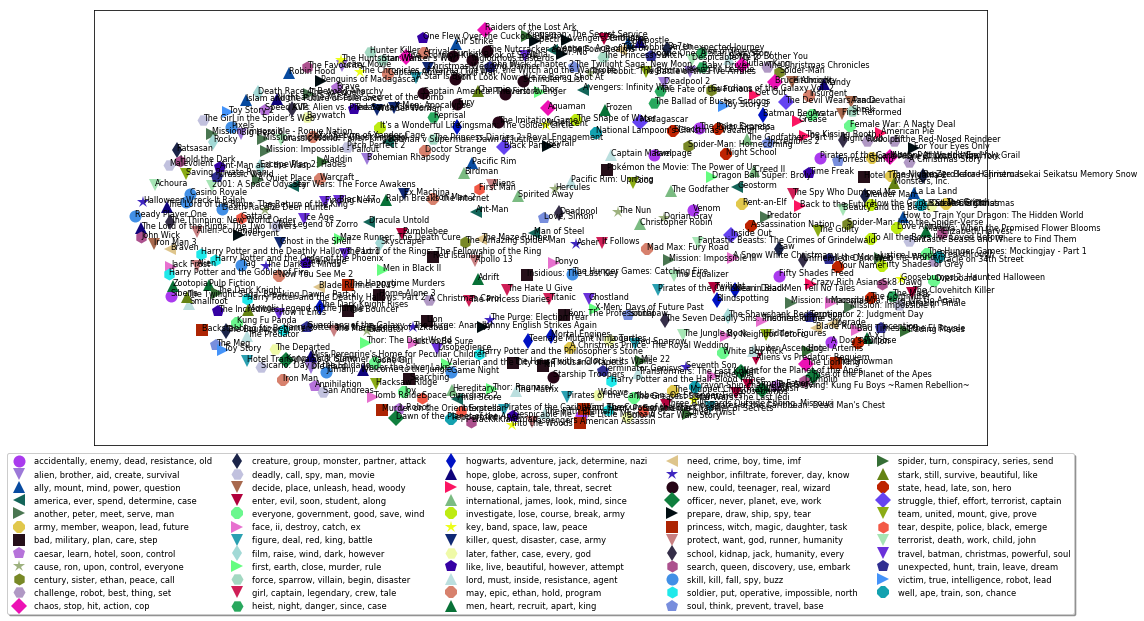

In [105]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 

In [218]:
from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix


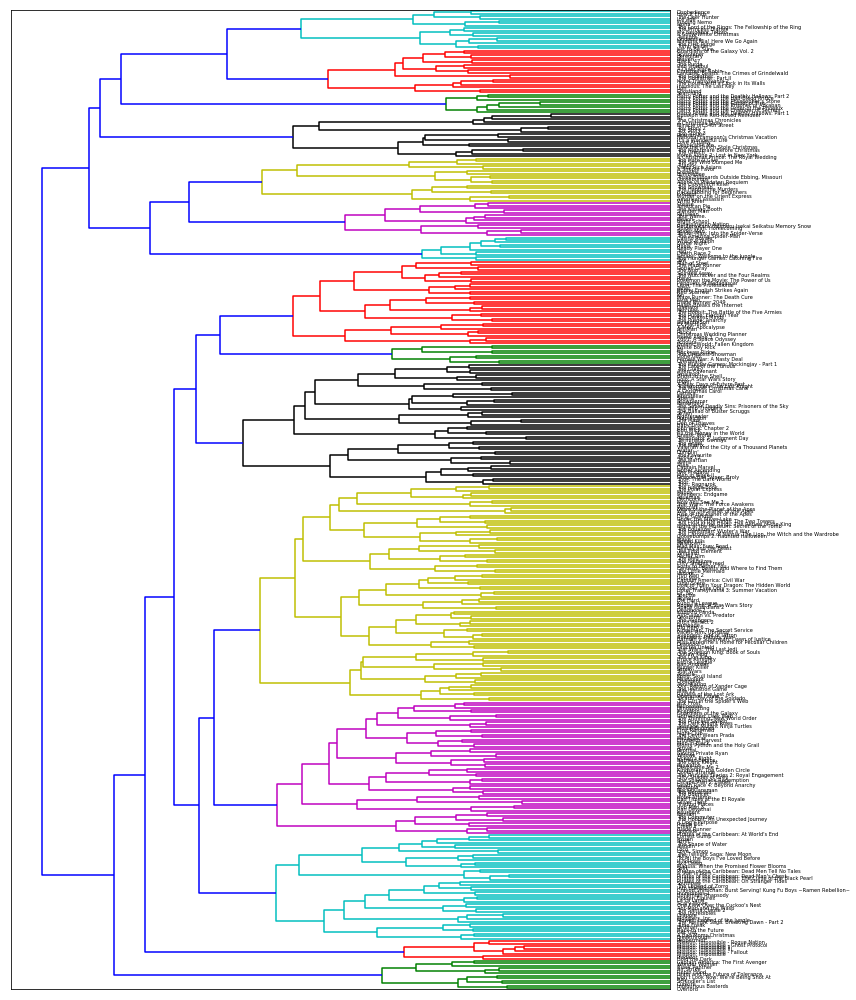

In [219]:
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=400)

# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(12,14))